# Dewhirst Final Report Work
* Nick Dewhirst (nickdew@umich.edu)
* Edited: April 19, 2023
* Scroll to "Data Formatting and Analysis" were my work starts

### Initialising a cyclone object

The first step to using the TC custom dataframes is to import the track_error module. Think of this like a C++ .h file from 101, or like a python library. Once you import the module, you can use it like you would use a python library (e.g. numpy). 


You need to have the module in the same directory as the notebook you are working in to use it, so work in the errorCalcModules directory when you are doing analysis, or define a filepath to the module before you import it.


You need all of the imports below to do this, as they are dependecies for the cyclone module itself.

In [62]:
# perform imports
import numpy as np
import track_error as te # the name you use to import this is arbitrary, I just used te bc it is an easy shorthand

Once you have your imports, you can start to initialise your Cyclone objects. 

The only important thing here is the way your csv files are stored in their directories. You need to have each TC's csv files stored in a seperate directory so that the string parsing can work correctly. I will probably fix this at some point so that it can be done by just storing everything in one directory, but right now I can't be bothered to write the function... (sorry ANL...)


I have organised the files on the github repo the same way that I have organised the files on my laptop when I tested all the code (TBA...), so if you clone the repo exactly you should have 0 problems with this. If you want to do this from scratch, you want to change the directory structure, or you have other models you want to include, this is how I have my directories structured:


```
.../tcTracks/cycName/stormName-year-month-day-hour.csv
```

All TIGGE tracks should be stored this way because the function uses the directory name to extract the name and year of the storm. I think this is a useful and organised way to store all of the data anyway, so I doubt I will change the syntax as it stops me getting lazy with file organisation while letting me be a lazy coder :)


All you need to do to initialise a cyclone object is call the cyclone constructor, called generate_cyclone(). This takes only a filepath to a directory as an argument and does all of the work for you from there.

In [85]:
#Here we initialize one cyclone.
#The filepath must be changed for each tropical cyclone to access the correct data.
#Simply change the name of the storm at the end of the filepath and run the cell.
filepath = "/Users/nweat/Downloads/hurricane-verification-main/hurricane-verification-main/tcTracks/Laura"
cyclone = te.generate_cyclone(filepath)

reading file: Laura-2020-08-22-00.csv
reading file: Laura-2020-08-22-12.csv
reading file: Laura-2020-08-23-00.csv
reading file: Laura-2020-08-23-12.csv
reading file: Laura-2020-08-24-00.csv
reading file: Laura-2020-08-24-12.csv
reading file: Laura-2020-08-25-00.csv
reading file: Laura-2020-08-25-12.csv
reading file: Laura-2020-08-26-00.csv
reading file: Laura-2020-08-27-00.csv
reading file: Laura-2020-08-29-00.csv


C:\Users\nweat\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nweat\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Data Formatting and Analysis

For increased efficiency, we decided to write 2 functions, "fftTrackErrorPlot" and "fftIntensityErrorPlot", to analyze and better format the track and intensity error data. 

#### Formatting and Chronological Ordering
First, we defined the set of model run forecasts for each cyclone as "Output" and iterated through it to access all of the intialization times and track errors for each tropical cyclone. We merged these separate lists of times and track errors, "RawT" and "RawTE", into a more condensed list of tuples, "TTE", that could then be sorted in chronological order using Python's "sorted" function. 

Once these are chronologically ordered, the function iterates through each tuple in the sorted list, "SortedTTE", appending each corresponding time and track error item into new lists. The lists are converted into arrays, which allows to finally plot time and track error against each other and perform our analysis techniques.

#### Polynomial Fits
The resulting error plots in the first sublot generally have an increasing trend over time, so in an attempt to detrend and increase stationarity, we applied secondary polynomial fits to each curve and subtracted these from the actual errors to yield track errors centered around 0 kilometers. These are shown in the second and third subplots in the figure. These fits allow us to see the smaller scale trends in error better without clutter from the long term trend. 

After applying first through fourth degree polynomial fits, we decided that the second degree fits detrended the data best and matched the shapes of the actual error curves pretty well. Fits of higher degrees can become too sensitive to small fluctuations in the data, but any degree from 2 to 4 applied on these error curves produce fairly similar detrended data.

There is a set of if and else statements involved in our functions because one of EPS runs for Cristobal was so short that the polyfit function did not have enough points to create a second degree polynomial fit from it. A linear fit was applied to this one run instead, and because it was so short, the difference between a first and second degree fit is negligible. It is essentially like making a linear approximation for a small window along a higher order function: they are usually good approximations when the window is apropriately small.

#### Fourier Transforms
Finally, we applied Fourier transforms to the newly detrended error to see if there are any persistent oscillations in the track errors. We also found the frequency spectrum for each EPS model run of the cyclones and plotted the amplitudes from the Fourier transform against their corresponding frequencies. We used a timestep (dt) of 1/4 to get frequencies in cycles/day because the model initializes every 6 hours, meaning 4 initialization times per day. The transforms are plotted in the fourth subplot in the figure.

#### Other Notable Information
The "fftIntensityErrorPlot" function farther down works the exact same way as fftTrackErrorPlot but uses the intensity errors instead of track errors.

The "merge" function immediately below was used to combine the separate lists of times and errors into a new list of tuples in both the fftTrackErrorPlot and fftIntensityErrorPlot functions. The "colorFader" function was used to create a pleasing and distinguishable gradient of colors for all of our plotted lines, and each color corresponds to each model run initialization time for each storm.

In [86]:
#Import the needed Python libraries for our analysis.
import matplotlib as mpl
import datetime as dt
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.ndimage import uniform_filter1d

#This function is used because of how the data was stored and is implemented into both of our plotting functions below.
def merge(list1, list2):
    '''Arguments:
    list1, list2: Two lists of data to combine into a list of tuples.
    
    This function zips two separate lists into a condensed list of tuples to be sorted later on'''
    merged_list = tuple(zip(list1, list2))
    return merged_list

#This function is used to create a pleasing and distinguishable gradient of colors for all of our plotted lines. 
def colorFader(c1,c2,mix=0):
    '''Arguments:
    c1, c2: Two colors that we would like to create a gradient of colors out of.
    
    mix: A number that tells the function how to combine each color.
    
    This function fades two matplotlib colors together to create a gradient.'''  
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

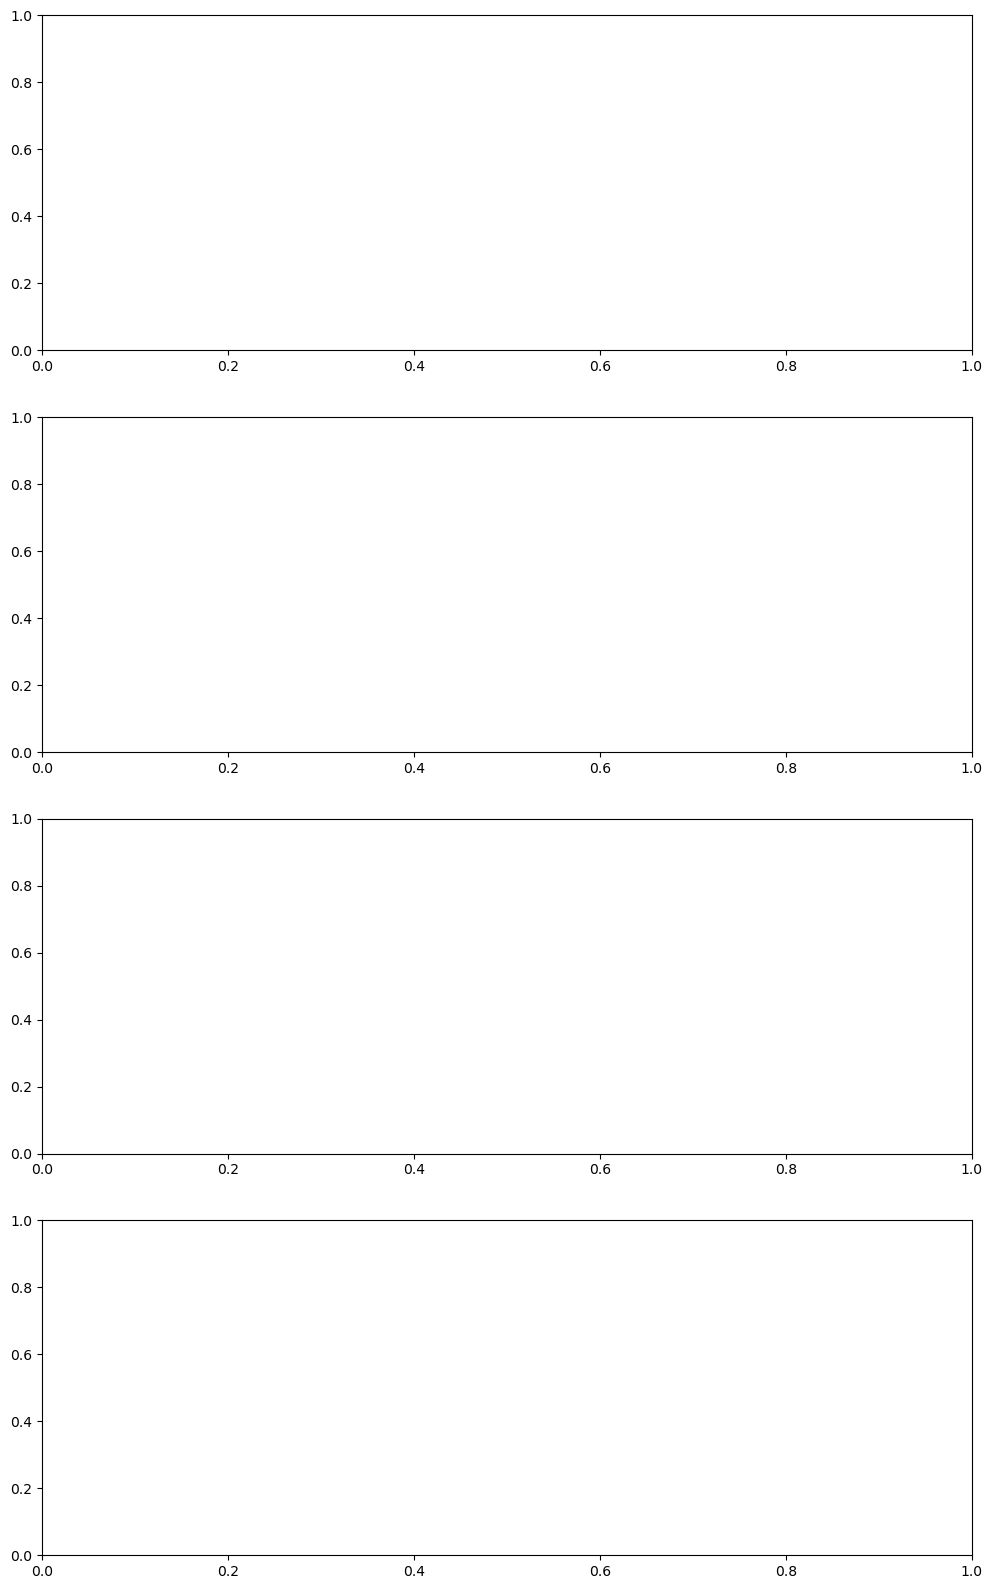

In [87]:
def fftTrackErrorPlot(RunNumber, ax1, ax2, ax3, ax4, mix):
    
    '''Arguments:
    RunNumber: A range of numbers corresponding to the number of EPS model runs per cyclone.
    
    ax1, ax2, ax3, ax4: A set of axes for each subplot in the figure that will be generated.
    
    mix: a range of numbers corresponding to RunNumber that inherently tells the colorFader function 
    how to combine the colors we select for our plots. Each number creates a slightly different color
    and yields a gradient of colors, one for each model run.
    
    This function creates a figure with 4 subplots for actual track error against time, 
    second degree polynomial fits of the track error against lead time from model initialization, 
    detrended track error data by subtracting the polynomial fits from the actual errors,and fast 
    Fourier transforms of the track error data for each model run.'''

    #All the model output variables come in a big list of tuples. They are not ordered in any specific way.
    Output = cyclone.ecmwf.runs[RunNumber].forecasts

    #Get the model run initialization times and respective track errors out of the large list of tuples.
    RawT = [cyclone.ecmwf.runs[RunNumber].forecasts[idx].time for (idx, fcst) in enumerate(Output)]
    RawTE = [cyclone.ecmwf.runs[RunNumber].forecasts[idx].track_error for (idx, fcst) in enumerate(Output)]
    
    #Create a separate list of tuples with the initialization times and track errors.
    TTE = merge(RawT, RawTE)
    
    #Sort the tuples in chronological order to plot them correctly for our analysis.
    SortedTTE = sorted(TTE, key = lambda x: x[0])
    
    #Create empty lists to append the times and track errors into from the list of tuples.
    TimeList = []
    TrackErrorList = []
    for i in SortedTTE:
        TimeList.append(i[0])
        TrackErrorList.append(i[1])
    
    #Convert the new intiailization time and track error lists into arrays.
    Time = np.array(TimeList)
    TrackError = np.array(TrackErrorList)
    
    #Create a range of times in a non-datetime format and calculate the polynomial coeffieicents so polyfit can work.
    PolyfitTime = np.arange(0,len(Time)*6,6)
    if len(Time) <= 3:
        coeffs = np.polyfit(PolyfitTime, TrackError, 1)
    else:
        coeffs = np.polyfit(PolyfitTime, TrackError, 2)

    #Create the polynomial fit.
    Trendline = np.polyval(coeffs, PolyfitTime)

    dt = 1/4 #Units of fraction of a day for fftfreq.
    N = Time.size #Length of time series.
    
    #Detrend the data buy subtracting the trendlines from track errors and take the Fourier transform of that. 
    TrackErrorfft = fft(TrackError - Trendline)

    #Get the frequencies in cycles/day.
    Freqs = fftfreq(N, dt)
    
    #Get the needed amplitudes by indexing into the positive values of the Fourier Transform and normalizing them.
    TrackErrorAmps = 1/N * np.abs(TrackErrorfft[1:N//2])
    
    #For the labels of each subplot so we can compare each model run based on initialization time.
    InitTime = TimeList[0]

    #First set of axes for track error vs. time on first subplot.
    ax1.plot(Time, TrackError, c = colorFader('red', 'blue', mix))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Track Error (km)')
    ax1.set_title('Track Error for each EPS Mean Run of TC Cristobal')
    
    #Second set of axes for the polynomial fits vs. time.
    ax2.plot(PolyfitTime, Trendline, c = colorFader('red', 'blue', mix))
    ax2.set_xlabel('Lead Time (hours) from Model Initialization')
    ax2.set_ylabel('Track Error (km)')
    ax2.set_title('Second Degree Polynomial Fits for each EPS Mean Run of TC Cristobal')
    
    #Third set of axes for the detrended track error data.
    ax3.plot(Time, TrackError - Trendline, c = colorFader('red', 'blue', mix))
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Detrended Track Error (km)')
    ax3.set_title('Detrended Track Error Data for each EPS Mean Run of TC Cristobal')
    
    #Fourth set of axes for the fourier transforms and frequencies.
    ax4.plot(Freqs[1:N//2], TrackErrorAmps, c = colorFader('red', 'blue', mix))
    ax4.set_xlabel('Frequency (cycles/day)')
    ax4.set_ylabel('Amplitude (km)')
    ax4.set_title('Frequency Spectra for Detrended Track Errors of each EPS Mean Run for TC Cristobal')
    
    return InitTime     

#Create the figure for the subplots and set positions for the axes.
fig1 = plt.figure(figsize=(12,20))
ax1 = fig1.add_subplot(411)
ax2 = fig1.add_subplot(412)
ax3 = fig1.add_subplot(413)
ax4 = fig1.add_subplot(414)

#### Important Note
The RunNumber argument must be changed for each cyclone analyzed. Because there are 16 EPS model runs for Delta, RunNumber is a range from 0 to 15. For Delta, there are 9 runs (range from 0 to 8), and for Laura, there are 11 (range from 0 to 10).

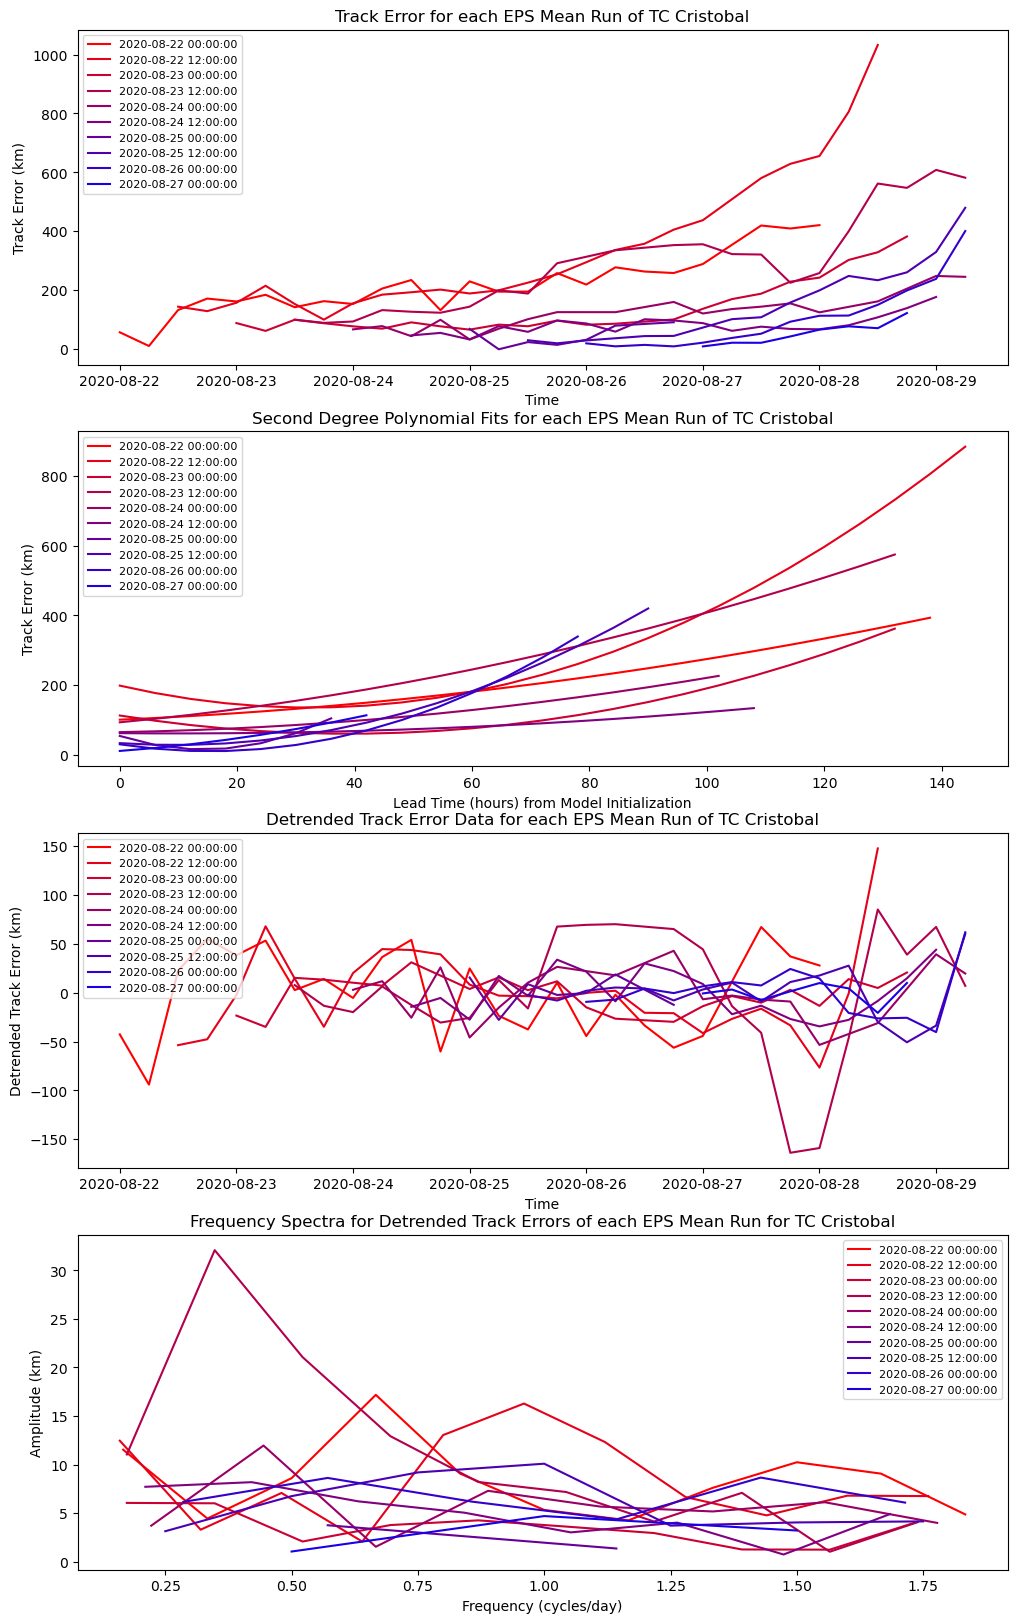

In [88]:
#Create an array of model run numbers to iterate through each and plot them. Must change for each storm.
RunNumber = np.arange(0,10,1)

#Create and empty list to append the labels into.
TrackErrorlabels = []

#Iterate through each run number to produce a label for each model run initialization time.
#This iteration also applies a different color in the gradient to each label.
for i in RunNumber:
    mix = i/len(RunNumber)
    labels = fftTrackErrorPlot(i, ax1, ax2, ax3, ax4, mix)
    TrackErrorlabels.append(labels)
    
#Add the labels to each subplot.
ax1.legend(TrackErrorlabels, loc = "upper left", fontsize = 8)
ax2.legend(TrackErrorlabels, loc = "upper left", fontsize = 8)
ax3.legend(TrackErrorlabels, loc = "upper left", fontsize = 8)
ax4.legend(TrackErrorlabels, loc = "upper right", fontsize = 8)

#Create the figure
fig1

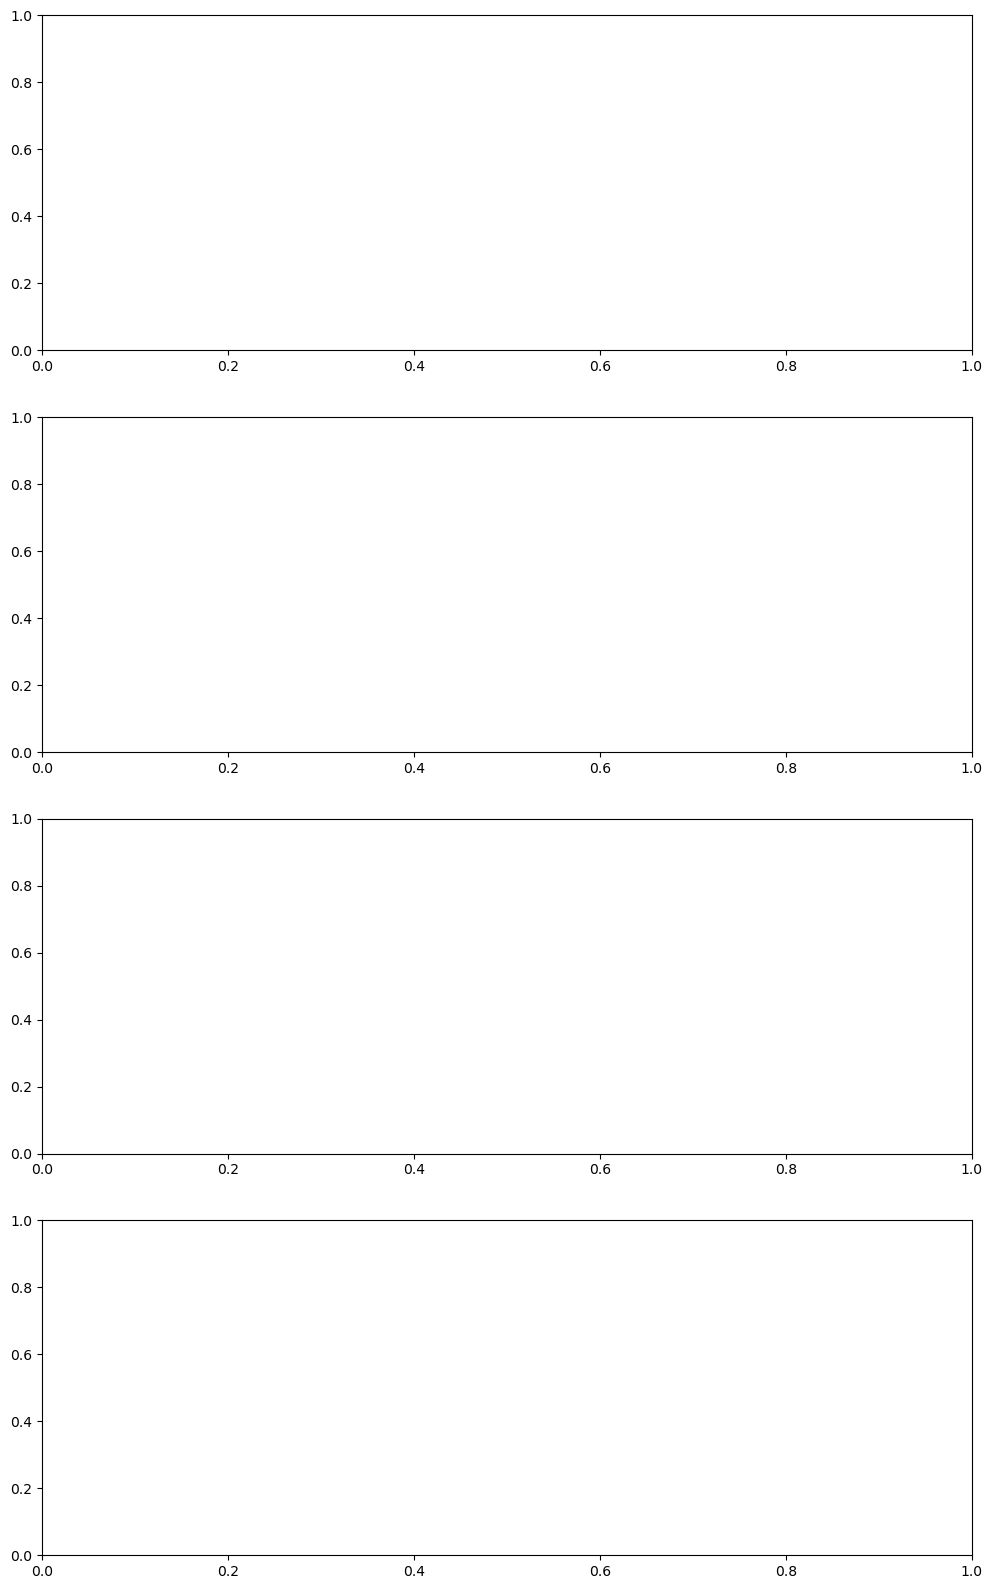

In [89]:
def fftIntensityErrorPlot(RunNumber, ax5, ax6, ax7, ax8, cf):
    '''Arguments:
    RunNumber: A range of numbers corresponding to the number of EPS model runs per cyclone.
    
    ax5, ax6, ax7, ax8: A set of axes for each subplot in the figure that will be generated.
    
    mix: a range of numbers corresponding to RunNumber that inherently tells the colorFader function 
    how to combine the colors we select for our plots. Each number creates a slightly different color
    and yields a gradient of colors, one for each model run.
    
    This function creates a figure with 4 subplots for actual intensity error against time, 
    second degree polynomial fits of the intensity error against lead time from model initialization, 
    detrended intensity error data by subtracting the polynomial fits from the actual errors, and fast 
    Fourier transforms of the intensity error data for each model run.'''

    #All the model output variables in a big list of tuples.
    Output = cyclone.ecmwf.runs[RunNumber].forecasts

    #Get the times and intensity errors out of the list.
    RawT = [cyclone.ecmwf.runs[RunNumber].forecasts[idx].time for (idx, fcst) in enumerate(Output)]
    RawIE = [cyclone.ecmwf.runs[RunNumber].forecasts[idx].intensity_error for (idx, fcst) in enumerate(Output)]
    
    #Create a list of tuples with the times and intensity errors.
    TIE = merge(RawT, RawIE)
    
    #Sort the tuples in chronological order to plot them correctly.
    SortedTIE = sorted(TIE, key = lambda x: x[0])
    
    #Empty lists to append the times and intensity errors into from the list of tuples.
    TimeList = []
    IntensityErrorList = []
    for i in SortedTIE:
        TimeList.append(i[0])
        IntensityErrorList.append(i[1])
    
    #Convert the new lists into arrays.
    Time = np.array(TimeList)
    IntensityError = np.array(IntensityErrorList)
    
    #Create a range of times in a non-datetime format and calculate the polynomial coeffieicents so polyfit can work.
    PolyfitTime = np.arange(0,len(Time)*6,6)
    if len(Time) <= 3:
        coeffs = np.polyfit(PolyfitTime, IntensityError, 1)
    else:
        coeffs = np.polyfit(PolyfitTime, IntensityError, 2)

    #Create the polynomial fit.
    Trendline = np.polyval(coeffs, PolyfitTime)

    dt = 1/4 #Units of fraction of a day for fftfreq.
    N = Time.size #Length of time series.
    
    #Detrend the data buy subtracting the trendlines from actual intensity errors and take the Fourier transform of that. 
    IntensityErrorfft = fft(IntensityError - Trendline)

    #Get the frequencies in cycles/year.
    Freqs = fftfreq(N, dt)
    
    #Get the needed amplitudes by indexing into the positive values of the Fourier Transform and normalizing them.
    IntensityErrorAmps = 1/N * np.abs(IntensityErrorfft[1:N//2])
    
    #For the labels of each subplot so we can compare each model run based on initialization time.
    InitTime = TimeList[0]

    #First set of axes for intensity error vs. time on first subplot.
    ax5.plot(Time, IntensityError, c = colorFader('red', 'blue', cf))
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Intensity Error (mbar)')
    ax5.set_title('Intensity Error for each EPS Mean Run of TC Cristobal')
    
    #Second set of axes for the polynomial fits vs. time.
    ax6.plot(PolyfitTime, Trendline, c = colorFader('red', 'blue', cf))
    ax6.set_xlabel('Lead Time (hours) from Model Initialization')
    ax6.set_ylabel('Intensity Error (mbar)')
    ax6.set_title('Second Degree Polynomial Fits for each EPS Mean Run of TC Cristobal')
    
    #Third set of axes for the detrended intensity error data.
    ax7.plot(Time, IntensityError - Trendline, c = colorFader('red', 'blue', cf))
    ax7.set_xlabel('Time')
    ax7.set_ylabel('Detrended Intensity Error (mbar)')
    ax7.set_title('Detrended Intensity Error Data for each EPS Mean Run of TC Cristobal')
    
    #Fourth set of axes for the fourier transforms and frequencies.
    ax8.plot(Freqs[1:N//2], IntensityErrorAmps, c = colorFader('red', 'blue', cf))
    ax8.set_xlabel('Frequency (cycles/day)')
    ax8.set_ylabel('Amplitude (mbar)')
    ax8.set_title('Frequency Spectra for Detrended Intensity Error of each EPS Mean Run for TC Cristobal')
    
    return InitTime     

#Create the figure for the subplots and set positions for the axes.
fig2 = plt.figure(figsize=(12,20))
ax5 = fig2.add_subplot(411)
ax6 = fig2.add_subplot(412)
ax7 = fig2.add_subplot(413)
ax8 = fig2.add_subplot(414)


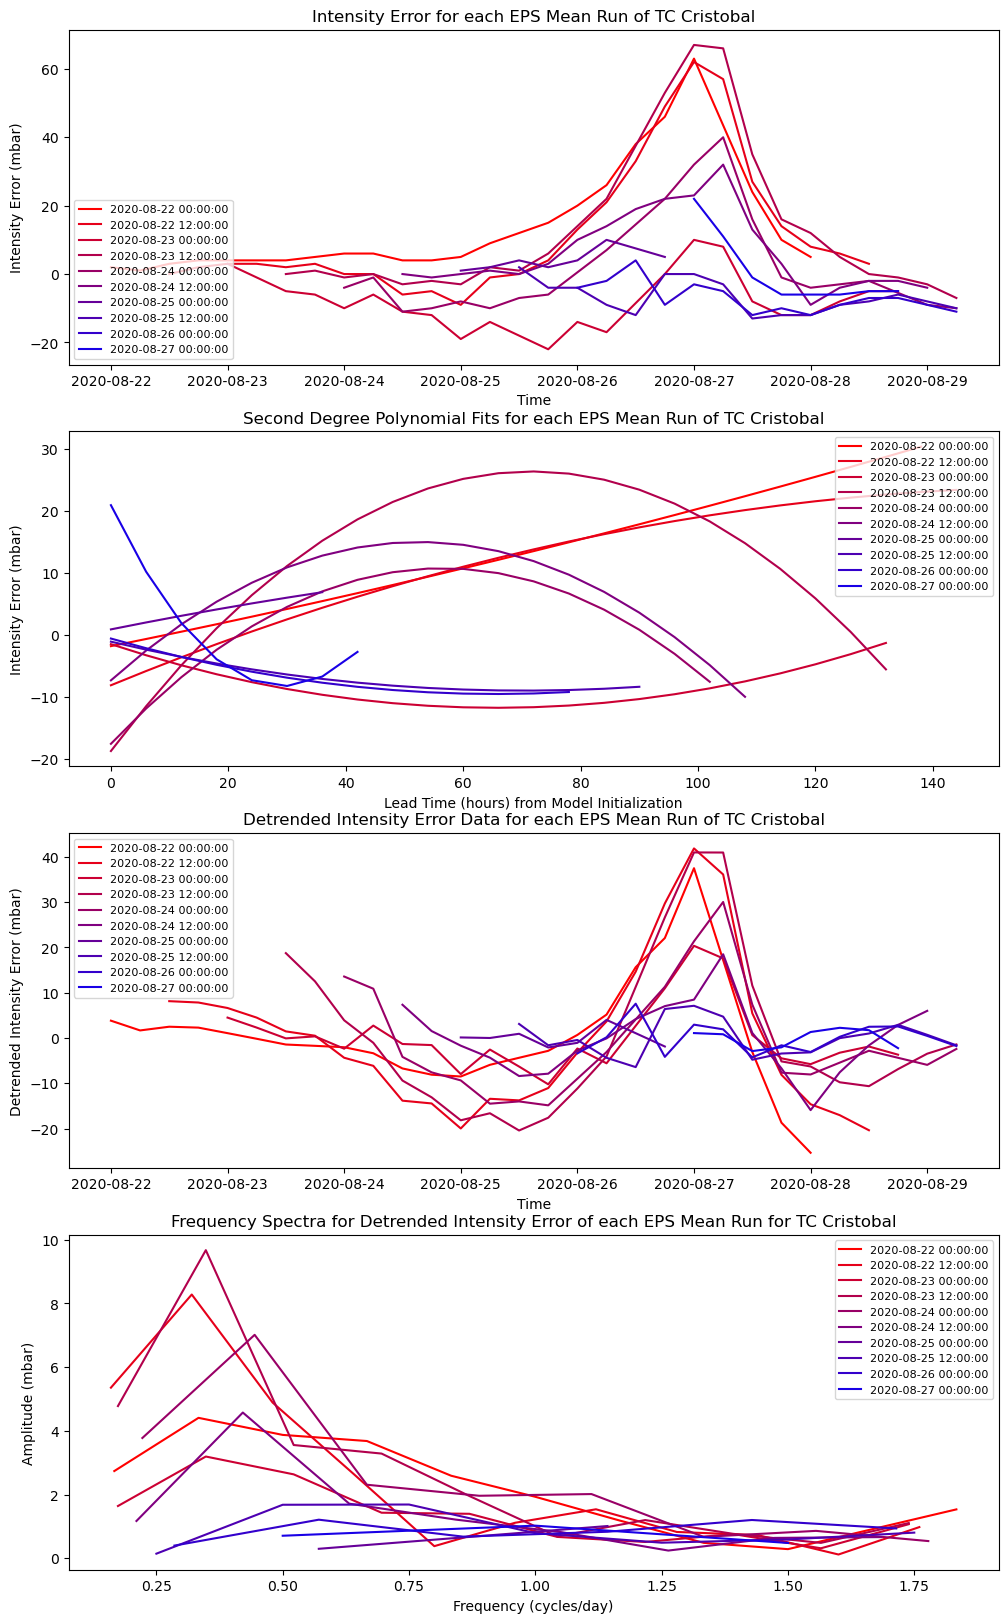

In [90]:

#Create empty list to append the labels into.
Intensitylabels = []

#Iterate through each run number to produce a label for each model run initialization time.
#This iteration also applies a different color in the gradient to each label.
for i in RunNumber:
    cf = i/len(RunNumber)
    labels = fftIntensityErrorPlot(i, ax5, ax6, ax7, ax8, cf)
    Intensitylabels.append(labels)

#Add the color labels to each subplot.
ax5.legend(Intensitylabels, loc = "lower left", fontsize = 8)
ax6.legend(Intensitylabels, loc = "upper right", fontsize = 8)
ax7.legend(Intensitylabels, loc = "upper left", fontsize = 8)
ax8.legend(Intensitylabels, loc = "upper right", fontsize = 8)

#Create the figure
fig2

### Results

For all of the cyclones, we can see that, generally, track error increases with time. Even looking at the raw data, we can see that there are some oscillations in the rate of increase of track error, as the track error for EPS runs that initialize early in the cyclone's lifetime tend to flatten out, or even decrease, towards the middle of the time window, and then increase again later on. When we detrend the track error with the polynomial fits, the oscillations are displayed even better in many of the early EPS runs.

#### Cristobal
Cristobal has the most pronounced dominant frequency signal in the track error of several EPS runs around 0.4 cycles/day, although there are some higher frequencies that also have a significant contribution. Some of these same runs also have a dominant frequency in intensity error oscillations around 0.4 cycles/day, but it's more spread out and less pronounced around a single frequency.

#### Delta
Delta has a similar percentage of EPS runs with a dominant frequency in track error oscillation around 0.4 cycles/day, considering that Delta only had 9 EPS runs, and Cristobal had 16. These frequencies are even more closely centered around 0.4 cycles/day with less noise at higher frequencies. One of the runs has a nearly matched frequency spectrum for both the track and intensity error, but, overall, the dominant frequency in the intensity errors for most of the EPS runs is less pronounced and at higher frequencies.

#### Laura
The dominant frequencies in track error for Laura's EPS runs are less clear than Delta's, and only one of the runs has a significant amplitude around 0.4 cycles/day. Interestingly, there is a greater dominant frequency signal in Laura's intensity errors around 0.4 cycles/day, opposite of Delta.

#### Extratropical Transition
For Cristobal specifically, there is a clear trend in the EPS runs towards the end of the cyclone's life to have improved track errors as the storm nears and undergoes its extratropical transition. An extratropical transition occurs when a tropical cyclone becomes dominated by mid-latitude dynamics when it exits the subtropics and resembles a cyclone that we would see here in Michigan.

Because a large fraction of Cristobal's life was spent moving north through the U.S. and eventually into Canada, it makes sense that the EPS would handle the storm better. These kinds of models tend to do better with midlatitude cyclones because of the equations that have been programmed into them, and some dynamics that we experience here in the midlatitudes can break down in the tropics, as the coriolis force is not as strong. 

Delta and Laura spent the vast majority of their lifetime in the (sub)tropics, and significant improvement in track error in EPS runs initializating towards the end of their lives is not as clear. This matches up with what we understand about the models, and further analysis could explore more storms to see if these findings hold.